## [Luis Alejandro Rodríguez Arenas](https://luigitoby.github.io/)  
## Cod. 202321287 
## Parte de G4
## Laboratorio 1 - Bono

## Importación de librerías necesarias

In [21]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sympy import symbols, Matrix, pi, cos, sin, simplify, eye, solve, acos, asin,  latex, atan2, pprint, init_printing, Derivative, sqrt
from sympy.physics.mechanics import ReferenceFrame, dynamicsymbols, init_vprinting, Point

# Formato mathjax, porque me gusta mejor estas derivadas
init_vprinting(use_latex='mathjax')

# Cinemática directa e inversa del robot tipo jack

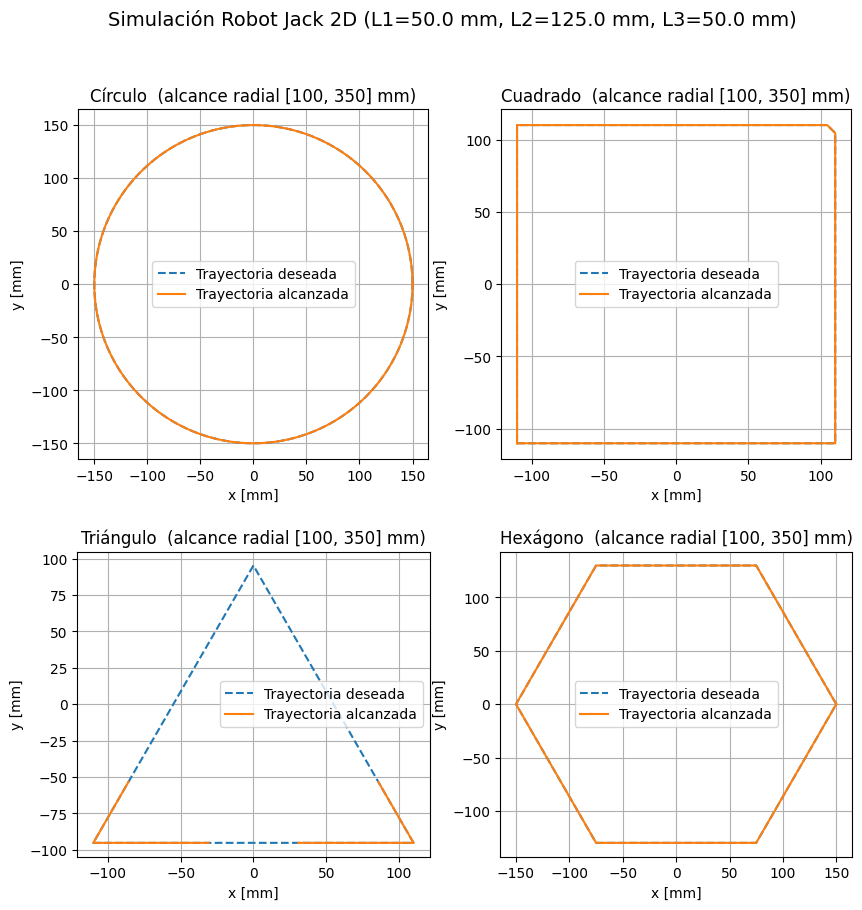

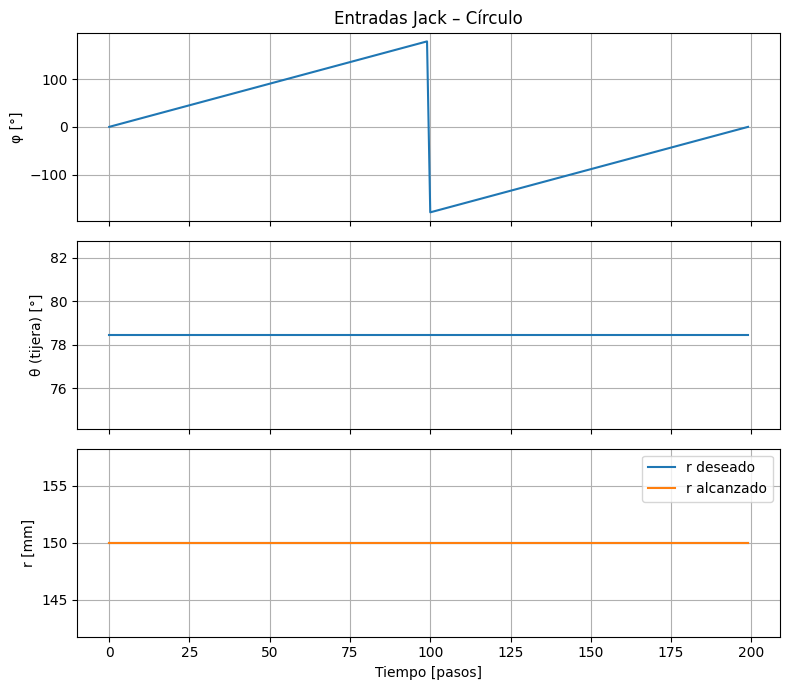

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --------- Modelo Jack (2D) ---------
# Geometría (mm)
L1, L2, L3 = 50.0, 125.0, 50.0

def r_from_theta(theta):
    # r(theta) = L1 + 2*L2*cos(theta) + L3
    return L1 + 2.0*L2*np.cos(theta) + L3

def theta_from_r(r):
    # Inversa radial: cos(theta) = (r - (L1+L3)) / (2*L2)
    c = (r - (L1 + L3)) / (2.0*L2)
    if np.any(np.isnan(c)) or (c < -1.0 or c > 1.0):
        return None
    # Por construcción física, usamos rama con theta ∈ [0, pi]
    return np.arccos(np.clip(c, -1.0, 1.0))

def fk_jack(phi, theta):
    # Cinemática directa en 2D
    r = r_from_theta(theta)
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    return x, y

def ik_jack_from_xy(x, y):
    # Dado (x,y): phi_d = atan2(y,x), r_d = sqrt(x^2+y^2)
    r = np.hypot(x, y)
    phi = np.arctan2(y, x)
    # Chequeo de alcanzabilidad
    r_min = L1 + L3
    r_max = L1 + 2.0*L2 + L3
    if (r < r_min) or (r > r_max):
        return None, None
    theta = theta_from_r(r)
    return phi, theta

# --------- Generadores de trayectorias (en XY) ---------
def trayectoria_circulo(radio=150.0, n_puntos=200):
    t = np.linspace(0, 2*np.pi, n_puntos, endpoint=True)
    return [(radio*np.cos(tt), radio*np.sin(tt)) for tt in t]

def trayectoria_cuadrado(lado=200.0, n_puntos=160):
    pts = []
    seg = n_puntos//4
    xs = np.linspace(-lado/2,  lado/2, seg, endpoint=False)
    ys = np.linspace(-lado/2,  lado/2, seg, endpoint=False)
    pts += [(x, -lado/2) for x in xs]
    pts += [( lado/2, y) for y in ys]
    pts += [(x,  lado/2) for x in xs[::-1]]
    pts += [(-lado/2, y) for y in ys[::-1]]
    pts.append(pts[0])
    return pts

def trayectoria_triangulo(lado=220.0, n_puntos=150):
    h = np.sqrt(3)/2 * lado
    V = [(0, h/2), (-lado/2, -h/2), (lado/2, -h/2), (0, h/2)]
    seg = n_puntos//3
    pts = []
    for i in range(3):
        x1, y1 = V[i]
        x2, y2 = V[i+1]
        xs = np.linspace(x1, x2, seg, endpoint=False)
        ys = np.linspace(y1, y2, seg, endpoint=False)
        pts += list(zip(xs, ys))
    pts.append(V[0])
    return pts

def trayectoria_hexagono(radio=150.0, n_puntos=180):
    V = [(radio*np.cos(i*np.pi/3), radio*np.sin(i*np.pi/3)) for i in range(6)]
    V.append(V[0])
    seg = n_puntos//6
    pts = []
    for i in range(6):
        x1, y1 = V[i]
        x2, y2 = V[i+1]
        xs = np.linspace(x1, x2, seg, endpoint=False)
        ys = np.linspace(y1, y2, seg, endpoint=False)
        pts += list(zip(xs, ys))
    pts.append(V[0])
    return pts

# --------- Simulación tipo “seguimiento” ---------
def simular_robot_jack(T_xy):
    """
    Para cada punto deseado (x_d, y_d):
      - Calcula (phi_d, theta) por IK del Jack.
      - Si es alcanzable, reconstruye (x_r, y_r) por FK.
      - Si no es alcanzable, marca (nan, nan).
    """
    tray_real = []
    phi_list, theta_list = [], []
    for (xd, yd) in T_xy:
        phi, theta = ik_jack_from_xy(xd, yd)
        if (phi is None) or (theta is None):
            tray_real.append((np.nan, np.nan))
            phi_list.append(np.nan)
            theta_list.append(np.nan)
        else:
            xr, yr = fk_jack(phi, theta)
            tray_real.append((xr, yr))
            phi_list.append(phi)
            theta_list.append(theta)
    return tray_real, np.array(phi_list), np.array(theta_list)

# --------- Alcance útil (para escoger trayectorias) ---------
r_min = L1 + L3
r_max = L1 + 2.0*L2 + L3
# Ej.: r_min=100 mm, r_max=350 mm con L1=50, L2=125, L3=50

# --------- Diccionario de trayectorias (en mm) ---------
trayectorias = {
    "Círculo": trayectoria_circulo(radio=150.0),
    "Cuadrado": trayectoria_cuadrado(lado=220.0),
    "Triángulo": trayectoria_triangulo(lado=220.0),
    "Hexágono": trayectoria_hexagono(radio=150.0),
}

# --------- Gráficas XY ---------
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs = axs.flatten()

for i, (nombre, tray) in enumerate(trayectorias.items()):
    tray_real, phi_seq, theta_seq = simular_robot_jack(tray)
    xd, yd = zip(*tray)
    xr, yr = zip(*tray_real)

    axs[i].plot(xd, yd, '--', label='Trayectoria deseada')
    axs[i].plot(xr, yr, '-',  label='Trayectoria alcanzada')
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].set_title(f"{nombre}  (alcance radial [{r_min:.0f}, {r_max:.0f}] mm)")
    axs[i].set_xlabel('x [mm]')
    axs[i].set_ylabel('y [mm]')
    axs[i].grid(True)
    axs[i].legend()

plt.suptitle(f"Simulación Robot Jack 2D (L1={L1} mm, L2={L2} mm, L3={L3} mm)", fontsize=14)
plt.show()

# --------- (Opcional) Ángulos y extensión vs tiempo para una trayectoria ---------
# Ejemplo: inspeccionar círculo
nombre = "Círculo"
tray = trayectorias[nombre]
tray_real, phi_seq, theta_seq = simular_robot_jack(tray)
r_seq = [np.hypot(x, y) for (x, y) in tray]
r_fk  = [np.hypot(x, y) for (x, y) in tray_real]

t = np.arange(len(tray))

fig, ax = plt.subplots(3, 1, figsize=(8,7), sharex=True)
ax[0].plot(t, np.degrees(phi_seq))
ax[0].set_ylabel("φ [°]")
ax[0].set_title(f"Entradas Jack – {nombre}")

ax[1].plot(t, np.degrees(theta_seq))
ax[1].set_ylabel("θ (tijera) [°]")

ax[2].plot(t, r_seq, label="r deseado")
ax[2].plot(t, r_fk,  label="r alcanzado")
ax[2].set_xlabel("Tiempo [pasos]")
ax[2].set_ylabel("r [mm]")
ax[2].legend()
for a in ax: a.grid(True)
plt.tight_layout()
plt.show()
